In [1]:
import sys
sys.path.insert(0, '/home/sxh/Research/AttentiveFP/code',)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="0"

In [3]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight


In [4]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import itertools
from sklearn.metrics import r2_score
import scipy

In [5]:
random_seed = 888 # 69, 88
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 4

number of all smiles:  4200
number of successfully processed smiles:  4200


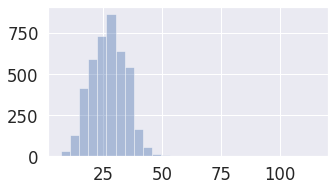

In [6]:
tasks = ['exp']
raw_filename = "/home/sxh/Research/AttentiveFP/data/Lipophilicity.csv"

feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

In [7]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print("not processed items")
uncovered_df

not processed items


,CMPD_CHEMBLID,exp,smiles,cano_smiles


In [8]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()



def predict(model, dataset):
    model.eval()
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
        
    preds = []
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        preds.append(mol_prediction.cpu().detach().numpy())


    return np.concatenate(preds,axis=0)

In [10]:
remained_df = remained_df.reset_index(drop=True)

file_path = "/raid/shenwanxiang/08_Robustness/dataset_induces/split"
random_seeds = [2, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

task_name = 'Lipop'


for seed in random_seeds:
    
    train_path = os.path.join(file_path, task_name,"%s" % seed, "train.csv")
    valid_path = os.path.join(file_path, task_name,"%s" % seed, "val.csv")
    test_path = os.path.join(file_path, task_name,"%s" % seed, "test.csv")

    pred_valid_path = os.path.join(file_path, task_name,"%s" % seed, "attfp_pred_val.csv")
    pred_test_path = os.path.join(file_path, task_name,"%s" % seed, "attfp_pred_test.csv")
    
    saved_valid_path = os.path.join(file_path, task_name,"%s" % seed, "attfp_saved_val.csv")
    saved_test_path = os.path.join(file_path, task_name,"%s" % seed, "attfp_saved_test.csv")
    
    
    df_train = pd.read_csv(train_path)
    df_valid = pd.read_csv(valid_path)
    df_test = pd.read_csv(test_path)

    print(seed, task_name)
    if (os.path.exists(pred_test_path)) & (os.path.exists(pred_valid_path)):
        continue
    test_df = remained_df[remained_df.smiles.isin(df_test.smiles)].reset_index(drop=True)
    valid_df = remained_df[remained_df.smiles.isin(df_valid.smiles)].reset_index(drop=True)
    train_df = remained_df[remained_df.smiles.isin(df_train.smiles)].reset_index(drop=True)


    print(len(train_df),len(valid_df),len(test_df),)

    x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
    num_atom_features = x_atom.shape[-1]
    num_bond_features = x_bonds.shape[-1]
    loss_function = nn.MSELoss()
    model = Fingerprint(radius, T, num_atom_features, num_bond_features,
                fingerprint_dim, output_units_num, p_dropout)
    model.cuda()

    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

    best_param ={}
    best_param["train_epoch"] = 0
    best_param["valid_epoch"] = 0
    best_param["train_MSE"] = 9e8
    best_param["valid_MSE"] = 9e8

    for epoch in range(800):
        train_MAE, train_MSE = eval(model, train_df)
        valid_MAE, valid_MSE = eval(model, valid_df)
        if train_MSE < best_param["train_MSE"]:
            best_param["train_epoch"] = epoch
            best_param["train_MSE"] = train_MSE
        if valid_MSE < best_param["valid_MSE"]:
            best_param["valid_epoch"] = epoch
            best_param["valid_MSE"] = valid_MSE
            if valid_MSE < 0.6:
                 torch.save(model, '/raid/shenwanxiang/08_Robustness/saved_models/model_%s' % task_name +prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
        if (epoch - best_param["valid_epoch"]) > 18:        
            break

        print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))

        train(model, train_df, optimizer, loss_function)

    # evaluate model
    best_model = torch.load('/raid/shenwanxiang/08_Robustness/saved_models/model_%s' % task_name+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

    best_model_dict = best_model.state_dict()
    best_model_wts = copy.deepcopy(best_model_dict)

    model.load_state_dict(best_model_wts)
    (best_model.align[0].weight == model.align[0].weight).all()
    _, valid_MSE = eval(model, valid_df)
    print("best epoch:",best_param["valid_epoch"],"\n","valid RMSE:",np.sqrt(valid_MSE))

    pred_test = predict(model, test_df)
    pd.DataFrame(pred_test, index = test_df['smiles'],
                 columns = [tasks]).to_csv(pred_test_path)

    pd.DataFrame(test_df[tasks].values, index = test_df['smiles'],
                 columns = [tasks]).to_csv(saved_test_path)

    pred_valid = predict(best_model, valid_df)
    pd.DataFrame(pred_valid, index = valid_df['smiles'], 
                 columns = [tasks]).to_csv(pred_valid_path)

    pd.DataFrame(valid_df[tasks].values, index = valid_df['smiles'],
                 columns = [tasks]).to_csv(saved_valid_path)

2 Lipop
16 Lipop
32 Lipop
64 Lipop
128 Lipop
256 Lipop
512 Lipop
1024 Lipop
2048 Lipop
4096 Lipop
